In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from datetime import timedelta
from scipy.stats import ttest_ind

from preprocess_and_exploration import data_folder

# Data Preprocess

## Load Dataset

In [2]:
audible_data = pd.read_csv(data_folder + '/audible_uncleaned.csv')
audible_data.head()

,name,author,narrator,time,releasedate,language,stars,price
0,At Home,By: Bill Bryson,Narrated by: Bill Bryson,16 hrs and 33 mins,Release date: 10-05-10,English,"4.5 out of 5 stars6,439 ratings",22.50
1,Preserved,By: Dean G. Lampros,Narrated by: Al Kessel,11 hrs and 10 mins,Release date: 03-26-24,English,Not rated yet,21.49
2,Venice,By: Dennis Romano,Narrated by: David Colacci,30 hrs and 45 mins,Release date: 02-27-24,English,4 out of 5 stars4 ratings,30.09
3,"Elevating Construction Senior Superintendents,...",By: Jason Schroeder,Narrated by: Kate Schroeder,7 hrs and 24 mins,Release date: 03-08-24,English,Not rated yet,14.99
4,Castles,By: Marc Morris,Narrated by: Derek Perkins,9 hrs and 18 mins,Release date: 04-04-17,English,4.5 out of 5 stars64 ratings,15.47


In [3]:
audible_data.rename(columns={'releasedate': 'release date'}, inplace=True)
audible_data.rename(str.title, axis='columns', inplace=True)
audible_data.head()

,Name,Author,Narrator,Time,Release Date,Language,Stars,Price
0,At Home,By: Bill Bryson,Narrated by: Bill Bryson,16 hrs and 33 mins,Release date: 10-05-10,English,"4.5 out of 5 stars6,439 ratings",22.50
1,Preserved,By: Dean G. Lampros,Narrated by: Al Kessel,11 hrs and 10 mins,Release date: 03-26-24,English,Not rated yet,21.49
2,Venice,By: Dennis Romano,Narrated by: David Colacci,30 hrs and 45 mins,Release date: 02-27-24,English,4 out of 5 stars4 ratings,30.09
3,"Elevating Construction Senior Superintendents,...",By: Jason Schroeder,Narrated by: Kate Schroeder,7 hrs and 24 mins,Release date: 03-08-24,English,Not rated yet,14.99
4,Castles,By: Marc Morris,Narrated by: Derek Perkins,9 hrs and 18 mins,Release date: 04-04-17,English,4.5 out of 5 stars64 ratings,15.47


In [4]:
audible_data.describe(include='all')

,Name,Author,Narrator,Time,Release Date,Language,Stars,Price
count,55235,55235,54749,55235,55235,55235,55235,55235
unique,52841,33933,19776,2351,5314,23,6736,1429
top,The Odyssey,By: Barrett Williams,Narrated by: Virtual Voice,4 mins,Release date: 04-21-24,English,Not rated yet,Free
freq,15,467,2823,172,353,52877,9202,11319


In [5]:
audible_data.dtypes

Name            object
Author          object
Narrator        object
Time            object
Release Date    object
Language        object
Stars           object
Price           object
dtype: object

## Author Column Preprocess

### Strip "By: "

In [6]:
audible_data['Author'] = audible_data['Author'].str.replace('"', '').str.replace('By: ', '').str.strip()
audible_data['Author'].head()

0        Bill Bryson
1    Dean G. Lampros
2      Dennis Romano
3    Jason Schroeder
4        Marc Morris
Name: Author, dtype: object

## Narrator Column Preprocess

### Strip "Narrated by: "

In [7]:
audible_data['Narrator'] = audible_data['Narrator'].str.replace('"', '').str.replace('Narrated by: ', '').str.strip()
audible_data['Narrator'].head()

0       Bill Bryson
1         Al Kessel
2     David Colacci
3    Kate Schroeder
4     Derek Perkins
Name: Narrator, dtype: object

## Time Column Preprocess

### Convert Time To Timedelta

In [8]:
def convert_to_timedelta(time_string):
    hours_match = re.search(r'(\d+)\s*hrs', time_string)
    minutes_match = re.search(r'(\d+)\s*mins', time_string)
    return timedelta(
        hours=int(hours_match.group(1)) if hours_match else 0,
        minutes=int(minutes_match.group(1)) if minutes_match else 0
    )

audible_data['Time'] = audible_data['Time'].apply(convert_to_timedelta)
audible_data['Time'].head()

0   0 days 16:33:00
1   0 days 11:10:00
2   1 days 06:45:00
3   0 days 07:24:00
4   0 days 09:18:00
Name: Time, dtype: timedelta64[ns]

## Release Date Column Preprocess

### Convert Release Date To Datetime

In [9]:
audible_data['Release Date'] = audible_data['Release Date'].str.replace('"', '').str.replace('Release date:', '').str.strip()
audible_data['Release Date'] = pd.to_datetime(audible_data['Release Date'], format='%m-%d-%y')
audible_data['Release Date'].head()

0   2010-10-05
1   2024-03-26
2   2024-02-27
3   2024-03-08
4   2017-04-04
Name: Release Date, dtype: datetime64[ns]

## Language Column Preprocess

In [10]:
audible_data['Language'] = audible_data['Language'].str.replace('"', '').str.strip().str.title()
audible_data['Language'].value_counts()

Language
English               52877
Spanish                1204
German                  510
French                  190
Italian                 162
Portuguese               89
Russian                  85
Japanese                 43
Danish                   18
Hindi                     9
Polish                    9
Mandarin Chinese          7
Arabic                    5
Swedish                   5
Afrikaans                 5
Dutch                     5
Hungarian                 3
Catalan                   2
Ukrainian                 2
Czech                     2
Turkish                   1
Simplified Chinese        1
Hebrew                    1
Name: count, dtype: int64

## Stars Column Preprocess

### Examine Rated Or Not

In [11]:
audible_data['Stars'] = audible_data['Stars'].replace('"', '').str.strip()
audible_data['Rated'] = ~audible_data['Stars'].str.contains('Not rated yet')

In [12]:
audible_data.loc[audible_data['Rated'] == True, ['Rated', 'Stars']].head()

,Rated,Stars
0,True,"4.5 out of 5 stars6,439 ratings"
2,True,4 out of 5 stars4 ratings
4,True,4.5 out of 5 stars64 ratings
5,True,5 out of 5 stars2 ratings
6,True,4.5 out of 5 stars188 ratings


In [13]:
audible_data.loc[audible_data['Rated'] == False, ['Rated', 'Stars']].head()

,Rated,Stars
1,False,Not rated yet
3,False,Not rated yet
11,False,Not rated yet
20,False,Not rated yet
22,False,Not rated yet


### Extract Rating From Stars

In [14]:
audible_data['Stars'] = audible_data['Stars'].str.replace(',', '')
extract = lambda cast, row, regex, group_num : cast(re.search(regex, row['Stars']).group(group_num)) if row['Rated'] else np.nan
audible_data['Number Of Rating Response'] = audible_data.apply(lambda row: extract(int, row, r'stars(\d+) rating', 1), axis=1).astype('Int64')
audible_data['Stars'] = audible_data.apply(lambda row: extract(float, row, r'(\d+(\.\d+)?) out of', 1), axis=1).astype('Float64')
audible_data = audible_data[list(audible_data.columns)[:-4] + ['Rated', 'Stars', 'Number Of Rating Response', 'Price']]
audible_data.rename(columns={'Stars': 'Stars (Max: 5)'}, inplace=True)

In [15]:
audible_data.loc[audible_data['Rated'] == True, ['Rated', 'Stars (Max: 5)', 'Number Of Rating Response']].head()

,Rated,Stars (Max: 5),Number Of Rating Response
0,True,4.5,6439
2,True,4.0,4
4,True,4.5,64
5,True,5.0,2
6,True,4.5,188


In [16]:
audible_data.loc[audible_data['Rated'] == False, ['Rated', 'Stars (Max: 5)', 'Number Of Rating Response']].head()

,Rated,Stars (Max: 5),Number Of Rating Response
1,False,<NA>,<NA>
3,False,<NA>,<NA>
11,False,<NA>,<NA>
20,False,<NA>,<NA>
22,False,<NA>,<NA>


## Price Column Preprocess

### Convert Price to Float

In [17]:
audible_data['Price'] = audible_data['Price'].replace('"', '').str.replace('Free', '0').str.replace(',', '').str.strip().astype('Float64')
audible_data['Price'].dtypes

Float64Dtype()

## Save Preprocessed Dataset

In [18]:
audible_data.to_csv(data_folder + '/audible.csv', index=False)

# Data Exploration 

In [19]:
audible_data.head()

,Name,Author,Narrator,Time,Release Date,Language,Rated,Stars (Max: 5),Number Of Rating Response,Price
0,At Home,Bill Bryson,Bill Bryson,0 days 16:33:00,2010-10-05,English,True,4.5,6439,22.5
1,Preserved,Dean G. Lampros,Al Kessel,0 days 11:10:00,2024-03-26,English,False,<NA>,<NA>,21.49
2,Venice,Dennis Romano,David Colacci,1 days 06:45:00,2024-02-27,English,True,4.0,4,30.09
3,"Elevating Construction Senior Superintendents,...",Jason Schroeder,Kate Schroeder,0 days 07:24:00,2024-03-08,English,False,<NA>,<NA>,14.99
4,Castles,Marc Morris,Derek Perkins,0 days 09:18:00,2017-04-04,English,True,4.5,64,15.47


In [20]:
audible_data.describe(include='all')

,Name,Author,Narrator,Time,Release Date,Language,Rated,Stars (Max: 5),Number Of Rating Response,Price
count,55235,55235,54749,55235,55235,55235,55235,46033.0,46033.0,55235.0
unique,52841,33933,19776,NaN,NaN,23,2,<NA>,<NA>,<NA>
top,The Odyssey,Barrett Williams,Virtual Voice,NaN,NaN,English,True,<NA>,<NA>,<NA>
freq,15,467,2823,NaN,NaN,52877,46033,<NA>,<NA>,<NA>
mean,NaN,NaN,NaN,0 days 08:07:04.704625690,2019-05-07 11:56:53.075042816,NaN,NaN,4.494862,848.85606,15.906506
min,NaN,NaN,NaN,0 days 00:00:00,1998-12-27 00:00:00,NaN,NaN,1.0,1.0,0.0
25%,NaN,NaN,NaN,0 days 03:38:00,2016-11-22 00:00:00,NaN,NaN,4.5,9.0,13.13
50%,NaN,NaN,NaN,0 days 07:13:00,2020-07-09 00:00:00,NaN,NaN,4.5,45.0,17.19
75%,NaN,NaN,NaN,0 days 10:40:00,2023-04-27 00:00:00,NaN,NaN,5.0,223.0,21.49
max,NaN,NaN,NaN,11 days 00:38:00,2026-01-01 00:00:00,NaN,NaN,5.0,294813.0,163.62


In [21]:
audible_data.dtypes

Name                                  object
Author                                object
Narrator                              object
Time                         timedelta64[ns]
Release Date                  datetime64[ns]
Language                              object
Rated                                   bool
Stars (Max: 5)                       Float64
Number Of Rating Response              Int64
Price                                Float64
dtype: object

## Dataset Characteristics

### Features and Entries

In [22]:
audible_data.shape

(55235, 10)

### Rated vs. Not Rated

In [23]:
(audible_data['Rated'].sum(), (~audible_data['Rated']).sum())

(46033, 9202)

### Audiobook Lengths

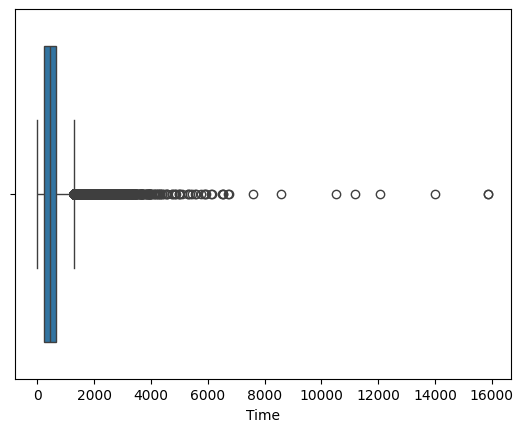

In [24]:
sns.boxplot(x=audible_data['Time'].dt.total_seconds() / 60)
plt.draw()

### Audiobook Ratings

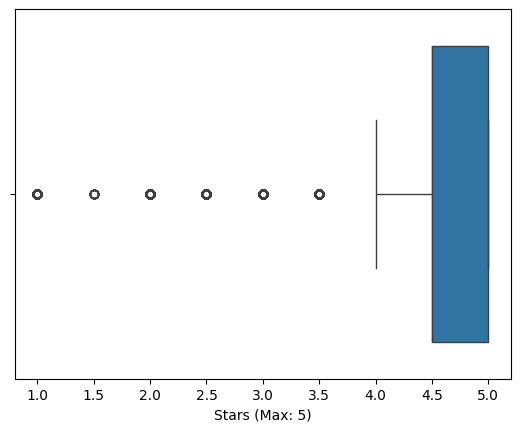

In [25]:
rated_audible_data = audible_data[audible_data['Rated'] == True]
sns.boxplot(x=rated_audible_data['Stars (Max: 5)'])
plt.draw()

### Audiobook Prices

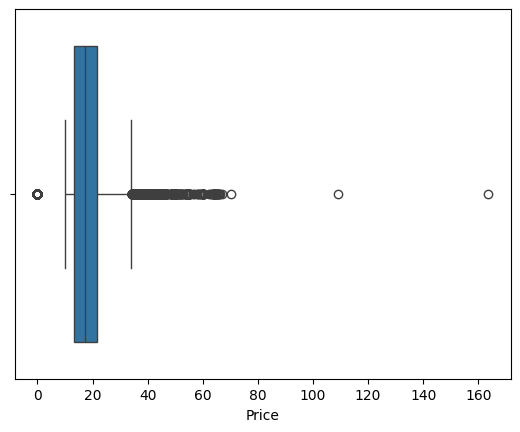

In [26]:
sns.boxplot(x=audible_data['Price'])
plt.draw()

### Conclusion

* The dataset consists of 55235 entries and 10 features, with 46033 entries rated and 9202 not.  
* The plot for Audiobook Lengths is skewed right, having most audiobooks under 2000 minutes. Several outliers indicate that some audiobooks lengths fall into the range of 2000 to 6000, with a few longer than 6000 minutes.
* The plot for Audiobook Ratings is heavily skewed left with few outliers.  
* The plot for Audiobook Prices is skewed right, having most audiobook prices under 40. Several outliers indicate that some audiobook prices fall into the range of 40 to 70, with a few higher than 70.

## Audiobook Lengths vs. Ratings

Null Hypothesis: There is no correlation between the length of audiobooks and their ratings.  
Alternative Hypothesis: There is a correlation between the length of audiobooks and their ratings.

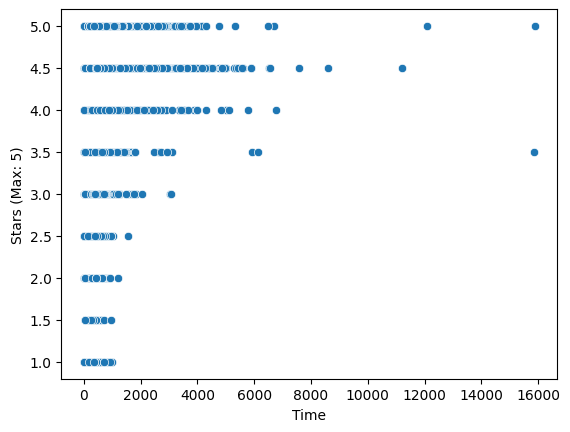

In [27]:
time_in_minutes = rated_audible_data['Time'].dt.total_seconds() / 60
sns.scatterplot(x=time_in_minutes, y=rated_audible_data['Stars (Max: 5)'])
plt.draw()

### T Test

In [28]:
time_in_minutes_median = time_in_minutes.median()
_, p_value = ttest_ind(
    rated_audible_data[time_in_minutes < time_in_minutes_median]['Stars (Max: 5)'],
    rated_audible_data[time_in_minutes >= time_in_minutes_median]['Stars (Max: 5)'],
    equal_var=False
)
p_value

1.0504911870116632e-27

### Conclusion

Suppose the significance level (alpha) is 0.05, and the p-value is 1.050e-27, which is less than alpha.  
Therefore, we reject the null hypothesis. That is, there is a correlation between the length of audiobooks and their ratings.

## Audiobook Ratings vs. Prices

Null Hypothesis: There is no correlation between the rating of audiobooks and their prices.  
Alternative Hypothesis: There is a correlation between the rating of audiobooks and their prices.

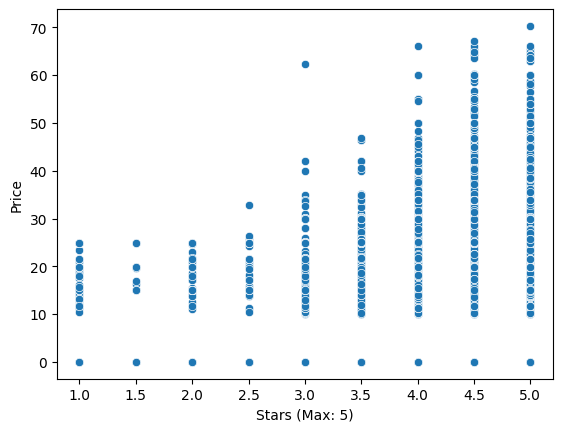

In [29]:
sns.scatterplot(x=rated_audible_data['Stars (Max: 5)'], y=rated_audible_data['Price'])
plt.draw()

### T Test

In [30]:
rating_mean = rated_audible_data['Stars (Max: 5)'].mean()
_, p_value = ttest_ind(
    rated_audible_data[rated_audible_data['Stars (Max: 5)'] < rating_mean]['Price'],
    rated_audible_data[rated_audible_data['Stars (Max: 5)'] >= rating_mean]['Price'],
    equal_var=False
)
p_value

5.5395985712783675e-171

### Conclusion

Suppose the significance level (alpha) is 0.05, and the p-value is 5.540e-171, which is less than alpha.  
Therefore, we reject the null hypothesis. That is, there is a correlation between the rating of audiobooks and their prices.